## Audio Identification based on Spectral Peaks

Prepared By Rahul Agarwal, March 2018

This notebook aims at implementing basic Audio Identification System . Here we try to identify given audio samples with already present audio files in database . The identification process is based on finding the
spectral peaks in both test sample and present audios files which act as identifier for that audio. We find
most powerful frequencies (frequencies corrosponding to maximum amplitute) which forms spectral envelope of test audio and try to match with frequency peaks of audio present in database. 

The certainity of test audio present in database audio is proportional to number of matched Peaks. Hence the audio files are retrieved in descending order of matched Peaks. 

In [1]:
from scipy import signal
import os
import sys
import numpy as np
import essentia.standard as ess
from scipy.fftpack import fft
import matplotlib.pyplot as plt
import scipy.spatial.distance as dist
import math

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd
import urllib.request
import zipfile
import os, sys,shutil
import matplotlib.pyplot as plt

In [2]:
#soundsDIR='../data/freesound/'
fs=44100
frameSize = 1024
windowSize = 1024
hopSize = 512
np.set_printoptions(precision=3)

''' Download the test audio file and audio files to which test audio is to be identified. 
   Two files furelise.wav and moonlight.wav has been used as existing database files.
   testAudio.wav is the file to me identified with these two files.

'audio' folder is created where all files are downloaded from url.
'''

soundsDIR='../../../data/audio/'

if not os.path.exists(soundsDIR):
    #Initialization
    url='http://rahulbcn27.github.io/audio.zip'
    filename='audio.zip'
    os.mkdir(soundsDIR)#creating the directory
    #Downloading the zip file from the url
    urllib.request.urlretrieve(url,filename)
    
    #Unzipping to a specific folder
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(soundsDIR)
    zip_ref.close()
    
    os.remove(filename)#Removing the zip file
    
    print('Data downloaded and unzipped to: ',soundsDIR)
else:
    print('Folder ',soundsDIR,' already exists, delete it if you want to re-download data')



Folder  ../../../data/audio/  already exists, delete it if you want to re-download data


In [8]:
# formation of Dataset of Existing Audio files. 

furelise = ess.MonoLoader(filename = soundsDIR+'furelise.wav', sampleRate = fs)()
moonlight = ess.MonoLoader(filename =  soundsDIR+'moonlight.wav', sampleRate = fs)()

#User Recorded Audio samples to identify with existing audio files
testAudio = ess.MonoLoader(filename =  soundsDIR+'testAudio.wav', sampleRate = fs)()
testAudio2 = ess.MonoLoader(filename =  soundsDIR+'testAudio2.wav', sampleRate = fs)()

#pass through low pass filter to reduce noise in each of test samples

testAudio = ess.LowPass()(testAudio) 
testAudio2 = ess.LowPass()(testAudio2)

#Next lines commented to reduce notebook size on github
#ipd.Audio(testAudio, rate=fs)
#ipd.Audio(testAudio2, rate=fs)#contains little noise and little reverb for real world simulation

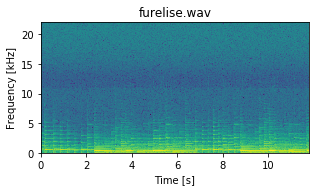

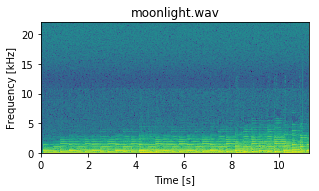

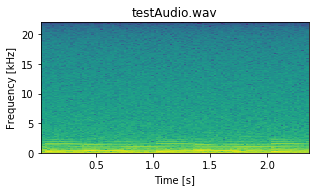

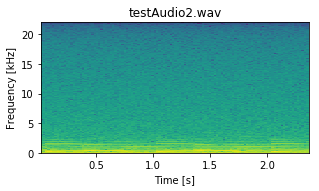

In [4]:
#Time-Frequency Spectogram of Audio Files
def getTimeFreqSpectogram(audio, fs,audioFilename):
    
    freqs, times, Sx = signal.spectrogram(audio, fs,
                                          nperseg=1024,
                                          detrend=False, scaling='spectrum')
   
    f, ax = plt.subplots(figsize=(4.8, 2.4))
    ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');
    ax.set_title(audioFilename)
    
getTimeFreqSpectogram(furelise, fs,'furelise.wav')
getTimeFreqSpectogram(moonlight, fs,'moonlight.wav')
getTimeFreqSpectogram(testAudio, fs,'testAudio.wav')
getTimeFreqSpectogram(testAudio, fs,'testAudio2.wav')

In [5]:
'''
Calculation of Spectral Peaks from Audio Samples using SpectralPeaks function on every frame of given audio.
It gives back list of magnitute and corrosponding frequencies which form spectral envelope and 
identity of sound .
'''
SpecPeaks = ess.SpectralPeaks()

spectrum = ess.Spectrum(size=frameSize)

window = ess.Windowing(size=windowSize, type='hann')

def getPeaksFromAudio(audio, frameSize, hopSize):
    
    peakArray = [] #audio peak Array to calculate
    
    for frame in ess.FrameGenerator(audio, frameSize=frameSize, hopSize=hopSize, startFromZero=True):        
        magSpec = spectrum(window(frame))  #magnitute Spectrum of a frame    
        freqPeakArray, magPeakArray = SpecPeaks(magSpec)  #freqPeakArray 
        
        magPeakArray = magPeakArray.tolist()  #converting np.array to list for extracting maximum amplitute
        freqPeakArray = freqPeakArray.tolist()
        magPeakMax = max(magPeakArray)   # maximum amplitute for this frame
      
        index = magPeakArray.index(magPeakMax)    
        freqPeakMax = freqPeakArray[index]   #corrosponding max frequency for peak magnitute 
      
        peakArray.append(int(round(freqPeakMax)))  # adding max frequency to peakArray
        
    return peakArray


In [6]:
#comparison of peak frequencies of two audio samples , returns array of matched peaks
def compareFreqlist(x_Array, y_Array):
    matchCount = 0
    matchArray = []
    for y in y_Array:
        for x in x_Array:          
            if x == y:
                matchCount = matchCount +1
                matchArray.append([x,y])
    return matchArray

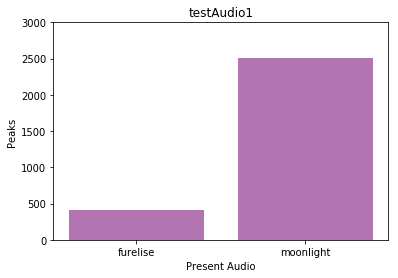

number of peaks matched with furelise 408
number of peaks matched with moonlight 2515
audio files identified in descending order 
moonlight.wav
furelise.wav


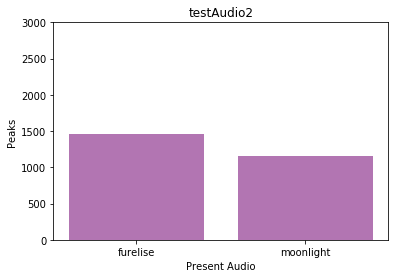

number of peaks matched with furelise 1460
number of peaks matched with moonlight 1151
audio files identified in descending order 
furelise
moonlight


In [7]:
#Get Frequencies of peaks for each audio file and test sample file. 

furelise_Peaks = getPeaksFromAudio(furelise, frameSize, hopSize)
moonlight_Peaks = getPeaksFromAudio(moonlight, frameSize, hopSize)
testAudio_Peaks = getPeaksFromAudio(testAudio, frameSize, hopSize)
testAudio2_Peaks = getPeaksFromAudio(testAudio2, frameSize, hopSize)

ipd.Audio(testAudio, rate=fs)

ipd.Audio(testAudio, rate=fs)

#Match peaks of each testAudioSample with Spectral peaks frequencies of audio files.

testAudioPeaks = [testAudio_Peaks, testAudio2_Peaks]
count = 1

for testAudioPeak in testAudioPeaks:

    fureliseMatch = compareFreqlist(furelise_Peaks, testAudioPeak)
    moonlightMatch = compareFreqlist(moonlight_Peaks, testAudioPeak)

    height = [len(fureliseMatch), len(moonlightMatch)]
    bars = ('furelise', 'moonlight')
    y_pos = np.arange(len(bars))
 
    # Create bars and choose color
    plt.bar(y_pos, height, color = (0.5,0.1,0.5,0.6))
 
    # Add title and axis names
    plt.title('testAudio'+str(count))
    plt.xlabel('Present Audio')
    plt.ylabel('Peaks')
 
    # Limits for the Y axis
    plt.ylim(0,3000)
 
    # Create names
    plt.xticks(y_pos, bars)
 
    # Show graphic
    plt.show()

    
    print("number of peaks matched with furelise", len(fureliseMatch))
    print("number of peaks matched with moonlight", len(moonlightMatch))

    print('audio files identified in descending order ')
    if(len(fureliseMatch) >= len(moonlightMatch)):    
        print('furelise')
        print('moonlight')
    else:
        print('moonlight.wav')
        print('furelise.wav')
    
    count=count+1